<a href="https://colab.research.google.com/github/Muun-Muun/clusterd_sattelites_optimization/blob/main/CA_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

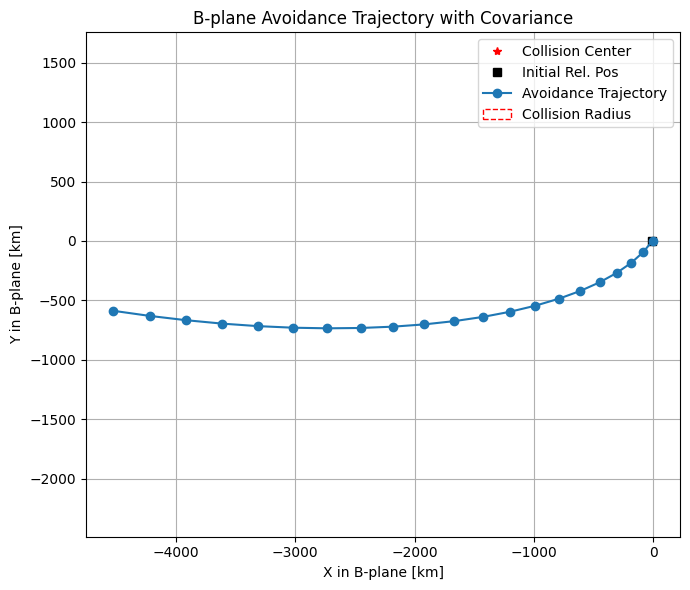

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import cvxpy as cp

# 초기 상대 위치/속도 (ECI 차이)
r_rel = np.array([-3.8775302, 1.839096, -1.637136])
v_rel = np.array([-7.748925325, -9.527159675, 7.6451696])
x0 = np.concatenate([r_rel, v_rel])

# B-plane basis
def normalize(v): return v / np.linalg.norm(v)
z_hat = normalize(v_rel)
y_hat = normalize(np.cross(r_rel, v_rel))
x_hat = np.cross(y_hat, z_hat)
T = np.vstack([x_hat, y_hat, z_hat])
r_b = T @ r_rel

# 공분산 → B-plane 투영
cov1 = np.array([[44.57575448, 81.67517511, -67.86876627],
                 [81.67517511, 158.45340296, -128.61692164],
                 [-67.86876627, -128.61692164, 105.49054256]])
cov2 = np.array([[2.31067078, 1.69905294, -1.41701646],
                 [1.69905294, 1.24957388, -1.04174164],
                 [-1.41701646, -1.04174164, 0.86926056]])
cov_sum = cov1 + cov2
cov_b = T @ cov_sum @ T.T
cov2d = cov_b[:2, :2]
inv_cov = np.linalg.inv(cov2d)

# 설정
N = 20
dt = 10.0
n = 0.0011
alpha = 1e4
rc = 0.01

# CW dynamics
A = np.eye(6)
A[:3, 3:] = dt * np.eye(3)
A[3, 0] = 3 * n**2 * dt
A[3, 4] = 2 * n * dt
A[4, 3] = -2 * n * dt
A[5, 2] = -n**2 * dt
B = np.zeros((6, 3))
B[3:, :] = dt * np.eye(3)

# 최적화
x = cp.Variable((6, N+1))
u = cp.Variable((3, N))
constraints = [x[:, 0] == x0]
for k in range(N):
    constraints += [x[:, k+1] == A @ x[:, k] + B @ u[:, k]]
    constraints += [cp.norm(u[:, k], 2) <= 5e-4]

final_r = x[0:2, N]
objective = cp.Minimize(cp.sum(cp.norm(u, axis=0)) + alpha * cp.quad_form(final_r, inv_cov))
cp.Problem(objective, constraints).solve()

# 궤적 시각화
path = x.value[0:2, :]
vals, vecs = np.linalg.eigh(cov2d)
angle = np.degrees(np.arctan2(*vecs[:, 1][::-1]))
width, height = 2 * np.sqrt(vals)

plt.figure(figsize=(7,6))
plt.plot(0, 0, 'r*', label='Collision Center')
plt.plot(r_b[0], r_b[1], 'ks', label='Initial Rel. Pos')
plt.plot(path[0], path[1], 'o-', label='Avoidance Trajectory')
# plt.gca().add_patch(Ellipse(r_b, width, height, angle, edgecolor='blue', facecolor='none', label='1-sigma Ellipse'))
plt.gca().add_patch(plt.Circle((0, 0), rc, color='red', fill=False, linestyle='--', label='Collision Radius'))

plt.xlabel('X in B-plane [km]')
plt.ylabel('Y in B-plane [km]')
plt.title('B-plane Avoidance Trajectory with Covariance')
plt.legend()
plt.axis('equal')
plt.grid(True)
plt.tight_layout()
plt.show()


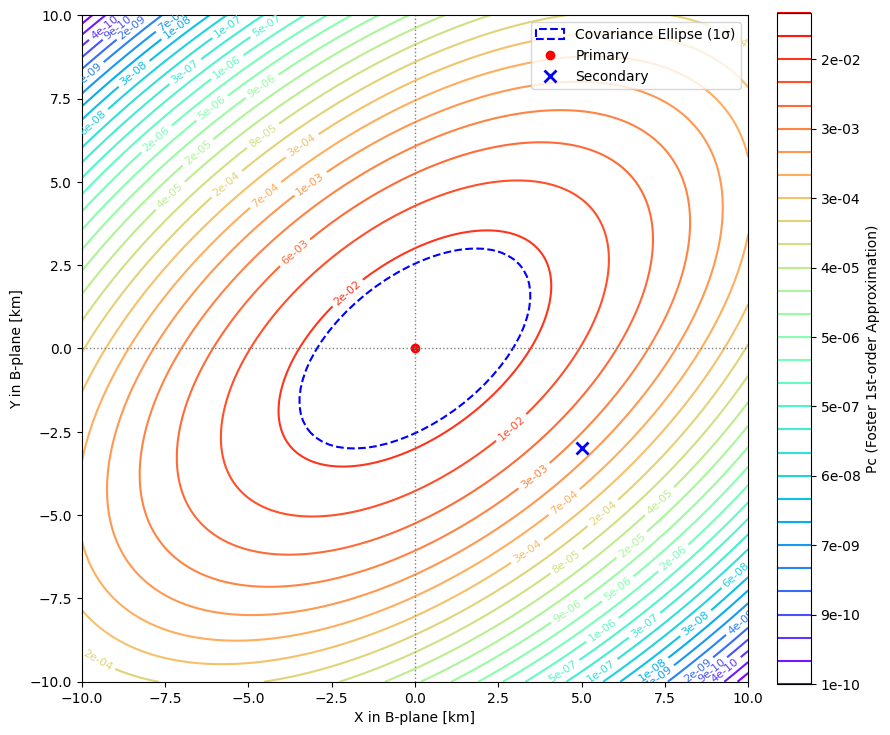

In [ ]:
# ✅ Foster 1차 근사 기반 충돌확률 Pc 시각화: 전체 코드

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from matplotlib.colors import LogNorm

# ------------------------------
# 1. 설정값
# ------------------------------
HBR_val = 1.0  # Hard Body Radius
r_secondary_far = np.array([5.0, -3.0])  # 상대 위성 위치 (Secondary)
C = np.array([[12.0, 5.5], [5.5, 9.0]])  # 결합 공분산 행렬
C_inv = np.linalg.inv(C)

# ------------------------------
# 2. 공분산 기반 시각화 요소
# ------------------------------
eigvals, eigvecs = np.linalg.eigh(C)
angle = np.degrees(np.arctan2(*eigvecs[:, 0][::-1]))
width, height = 2 * np.sqrt(eigvals)
sigma_x = np.sqrt(C[0, 0])
sigma_y = np.sqrt(C[1, 1])

# ------------------------------
# 3. 격자 생성
# ------------------------------
x_vals = np.linspace(-10, 10, 400)
z_vals = np.linspace(-10, 10, 400)
X, Z = np.meshgrid(x_vals, z_vals)

# ------------------------------
# 4. 마할라노비스 거리 제곱 및 1차 근사식
# ------------------------------
d2_grid = np.einsum('...i,ij,...j->...', np.dstack((X, Z)), C_inv, np.dstack((X, Z)))
pre_factor = HBR_val / (2 * sigma_x * sigma_y)
Pc_foster_1st = pre_factor * np.exp(-0.5 * d2_grid)

# ------------------------------
# 5. 플롯
# ------------------------------
fig, ax = plt.subplots(figsize=(9, 9))
levels = np.logspace(-10, -1, num=30)
contour = ax.contour(X, Z, Pc_foster_1st, levels=levels, cmap='rainbow', norm=LogNorm())
ax.clabel(contour, inline=True, fmt=lambda v: f"{v:.0e}", fontsize=8)

# 공분산 타원
cov_ellipse = Ellipse(xy=(0, 0), width=width, height=height, angle=angle,
                      edgecolor='blue', linestyle='--', lw=1.5, fc='none', label='Covariance Ellipse (1σ)')
ax.add_patch(cov_ellipse)

# 위치 표시
ax.plot(0, 0, 'ro', label='Primary')
ax.plot(*r_secondary_far, 'bx', markersize=8, markeredgewidth=2, label='Secondary')
ax.axhline(0, color='gray', linestyle=':', linewidth=1)
ax.axvline(0, color='gray', linestyle=':', linewidth=1)

# 레이아웃
ax.set_xlim([-10, 10])
ax.set_ylim([-10, 10])
ax.set_xlabel('X in B-plane [km]')
ax.set_ylabel('Y in B-plane [km]')
ax.set_aspect('equal')
ax.legend(loc='upper right')

# 컬러바
cbar = plt.colorbar(contour, ax=ax, fraction=0.046, pad=0.04, format='%.0e')
cbar.set_label('Pc (Foster 1st-order Approximation)')
plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from matplotlib.colors import LogNorm
import cvxpy as cp

# ------------------------------
# 1. 초기 상대 위치 및 속도 (ECI 차이)
# ------------------------------
r_rel = np.array([-3.8775302, 1.839096, -1.637136])
v_rel = np.array([-7.748925325, -9.527159675, 7.6451696])
x0 = np.concatenate([r_rel, v_rel])

# ------------------------------
# 2. B-plane 좌표계 구성
# ------------------------------
def normalize(v): return v / np.linalg.norm(v)
z_hat = normalize(v_rel)
y_hat = normalize(np.cross(r_rel, v_rel))
x_hat = np.cross(y_hat, z_hat)
T = np.vstack([x_hat, y_hat, z_hat])
r_b = T @ r_rel

# ------------------------------
# 3. 결합 공분산 및 Mahalanobis 거리용 변수
# ------------------------------
cov1 = np.array([[44.57575448, 81.67517511, -67.86876627],
                 [81.67517511, 158.45340296, -128.61692164],
                 [-67.86876627, -128.61692164, 105.49054256]])
cov2 = np.array([[2.31067078, 1.69905294, -1.41701646],
                 [1.69905294, 1.24957388, -1.04174164],
                 [-1.41701646, -1.04174164, 0.86926056]])
cov_sum = cov1 + cov2
cov_b = T @ cov_sum @ T.T
cov2d = cov_b[:2, :2]
inv_cov2d = np.linalg.inv(cov2d)

# ------------------------------
# 4. CW 동역학 설정
# ------------------------------
N = 200
dt = 10.0
n = 0.0011
A = np.eye(6)
A[:3, 3:] = dt * np.eye(3)
A[3, 0] = 3 * n**2 * dt
A[3, 4] = 2 * n * dt
A[4, 3] = -2 * n * dt
A[5, 2] = -n**2 * dt
B = np.zeros((6, 3))
B[3:, :] = dt * np.eye(3)

# ------------------------------
# 5. 회피기동 최적화 (cvxpy)
# ------------------------------
x = cp.Variable((6, N+1))
u = cp.Variable((3, N))
w_u = 1e3
w_coll = 1e0
Pc_max = 1e-3

constraints = [x[:, 0] == x0]
for k in range(N):
    constraints += [x[:, k+1] == A @ x[:, k] + B @ u[:, k]]
    # constraints += [cp.norm(u[:, k], 2) <= Pc_max]

final_r = x[0:2, N]
objective = cp.Minimize(w_u * cp.sum(cp.norm(u, axis=0)) + w_coll * cp.quad_form(final_r, inv_cov2d))
cp.Problem(objective, constraints).solve()

x_traj = x.value
bplane_path = x_traj[0:2, :]

# ------------------------------
# 6. Foster 1차 근사 기반 Pc 계산
# ------------------------------
HBR_val = 0.01  # [km]
sigma_x = np.sqrt(cov2d[0, 0])
sigma_y = np.sqrt(cov2d[1, 1])
pre_factor = HBR_val / (2 * sigma_x * sigma_y)

x_vals = np.linspace(-0.2, 0.2, 400)
y_vals = np.linspace(-0.2, 0.2, 400)
X, Y = np.meshgrid(x_vals, y_vals)
grid = np.dstack((X, Y))
d2 = np.einsum('...i,ij,...j->...', grid, inv_cov2d, grid)
Pc_foster = pre_factor * np.exp(-0.5 * d2)




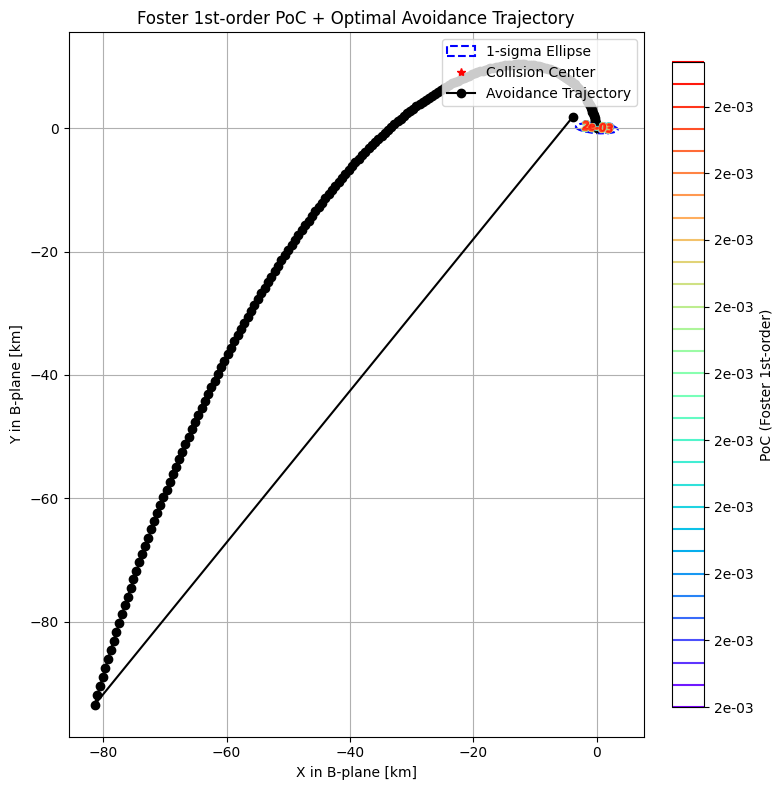

In [ ]:
# ------------------------------
# 7. 시각화
# ------------------------------
Pc_min = np.max([np.min(Pc_foster[Pc_foster > 0]), 1e-12])
Pc_max = np.max(Pc_foster)
levels = np.logspace(np.log10(Pc_min), np.log10(Pc_max), 30)

fig, ax = plt.subplots(figsize=(8, 8))
cs = ax.contour(X, Y, Pc_foster, levels=levels, cmap='rainbow', norm=LogNorm())
ax.clabel(cs, fmt='%.0e', fontsize=8)

# 1-sigma 타원
vals, vecs = np.linalg.eigh(cov2d)
angle = np.degrees(np.arctan2(*vecs[:, 0][::-1]))
width, height = 2 * np.sqrt(vals)
ellipse = Ellipse(xy=(0, 0), width=width, height=height, angle=angle,
                  edgecolor='blue', fc='none', lw=1.5, linestyle='--', label='1-sigma Ellipse')

ax.add_patch(ellipse)

# 회피 궤적 및 충돌 중심
ax.plot(0, 0, 'r*', label='Collision Center')
ax.plot(bplane_path[0], bplane_path[1], 'ko-', label='Avoidance Trajectory')

# 포맷
# ax.set_xlim([-0.2, 0.2])
# ax.set_ylim([-0.2, 0.2])
ax.set_xlabel('X in B-plane [km]')
ax.set_ylabel('Y in B-plane [km]')
ax.set_title('Foster 1st-order PoC + Optimal Avoidance Trajectory')
ax.set_aspect('equal')
ax.grid(True)
ax.legend(loc='upper right')
cbar = plt.colorbar(cs, ax=ax, fraction=0.046, pad=0.04, format='%.0e')
cbar.set_label('PoC (Foster 1st-order)')
plt.tight_layout()
plt.show()